In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

SEED = 47
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
plt.style.use('dark_background')

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} backend.")

Using mps backend.


In [2]:
# Define data transforms
transform = transforms.Compose([transforms.ToTensor()])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, 
                               transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, 
                              transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [3]:
# Variational AutoEncoder Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU()
        )
        # Latent space
        self.fc_mu = nn.Linear(64, 2)  # Mean of the latent space
        self.fc_logvar = nn.Linear(64, 2)  # Log variance of the latent space
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 28 * 28), nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        epsilon = torch.randn_like(std) 
        return mu + std * epsilon  # Reparameterized latent vector
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
# Loss function (Reconstruction loss + KL Divergence loss ~ ELBO)
def loss_function(reconstructed_x, x, mu, logvar, beta=0.9):
    # Reconstruction loss (MSE for MNIST images)
    MSE = nn.functional.mse_loss(
        reconstructed_x, x.view(-1, 28 * 28), 
        reduction='sum'
    )
    
    # KL Divergence loss
    # Calculate KL Divergence 
    # between learned distribution and standard normal (bivariate, prior)
    KL = -beta * 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + KL

In [5]:
# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        reconstructed, mu, logvar = model(images)
        loss = loss_function(reconstructed, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}")

Epoch 1/50, Loss: 15285.2554
Epoch 2/50, Loss: 11586.7639
Epoch 3/50, Loss: 11083.4447
Epoch 4/50, Loss: 10781.2728
Epoch 5/50, Loss: 10572.6048
Epoch 6/50, Loss: 10405.3866
Epoch 7/50, Loss: 10258.8899
Epoch 8/50, Loss: 10134.5283
Epoch 9/50, Loss: 10019.9649
Epoch 10/50, Loss: 9919.4505
Epoch 11/50, Loss: 9836.3590
Epoch 12/50, Loss: 9744.8833
Epoch 13/50, Loss: 9670.9032
Epoch 14/50, Loss: 9608.3854
Epoch 15/50, Loss: 9548.7525
Epoch 16/50, Loss: 9503.0692
Epoch 17/50, Loss: 9462.3527
Epoch 18/50, Loss: 9412.0956
Epoch 19/50, Loss: 9375.6170
Epoch 20/50, Loss: 9339.3036
Epoch 21/50, Loss: 9305.3525
Epoch 22/50, Loss: 9268.8976
Epoch 23/50, Loss: 9241.3404
Epoch 24/50, Loss: 9212.7804
Epoch 25/50, Loss: 9186.9957
Epoch 26/50, Loss: 9157.7100
Epoch 27/50, Loss: 9132.2370
Epoch 28/50, Loss: 9106.3630
Epoch 29/50, Loss: 9087.4329
Epoch 30/50, Loss: 9070.1503
Epoch 31/50, Loss: 9049.6586
Epoch 32/50, Loss: 9028.4834
Epoch 33/50, Loss: 9010.0085
Epoch 34/50, Loss: 8995.3961
Epoch 35/50, L

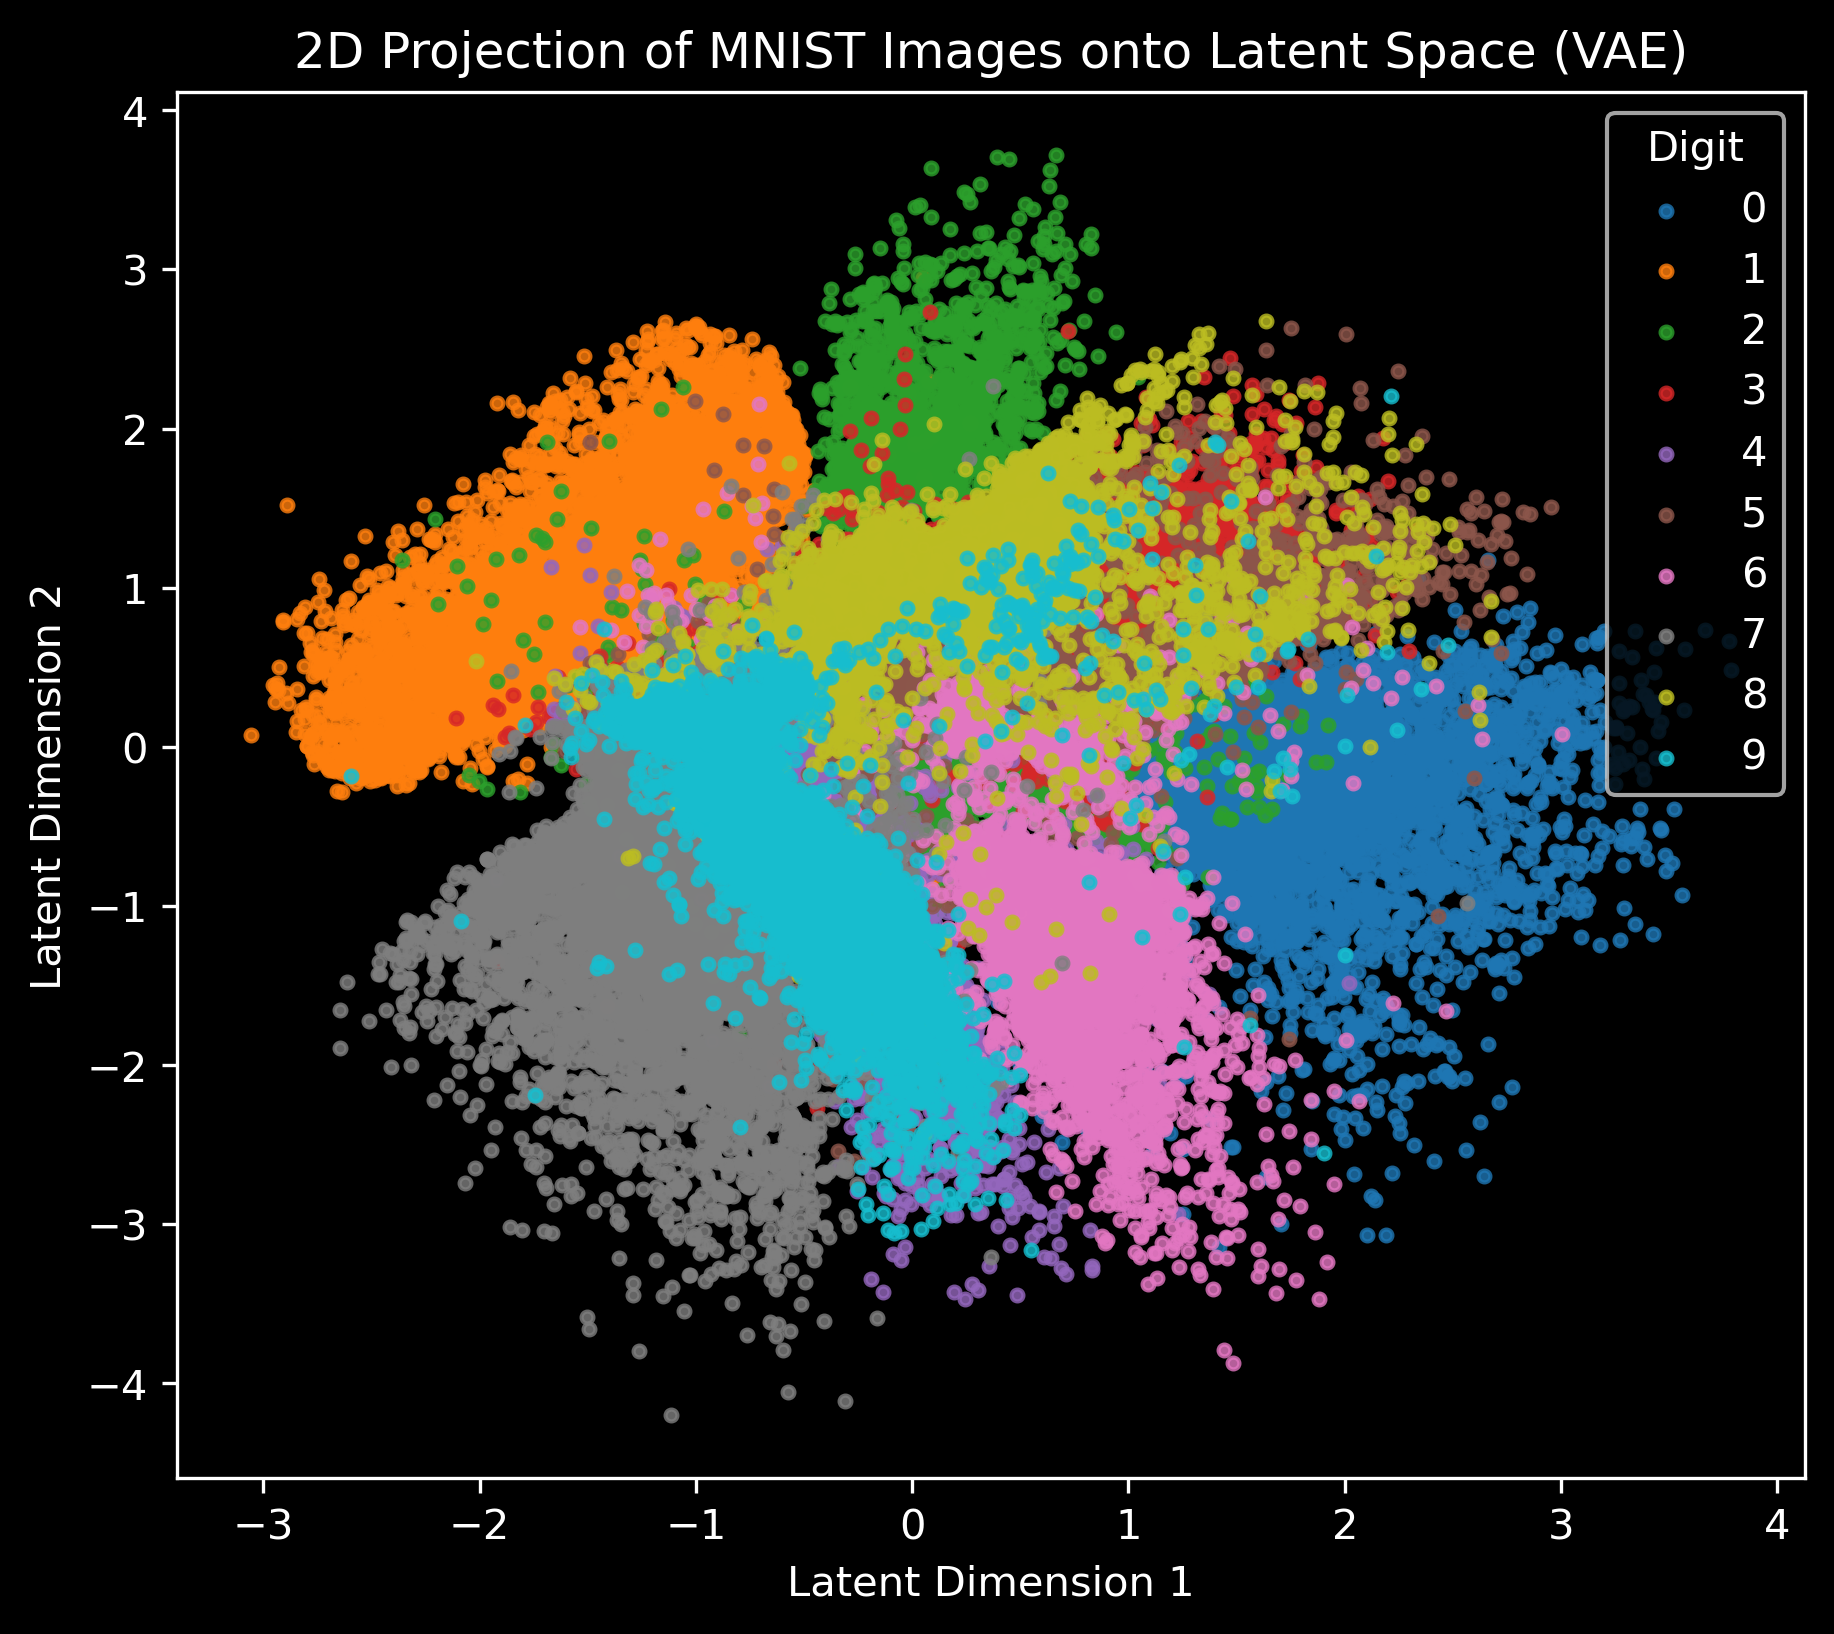

In [6]:
# Visualize the 2D Latent Space
def plot_latent_space(model, data_loader):
    model.eval()
    latent_space, labels = [], []
    with torch.no_grad():
        for images, y in data_loader:
            images = images.to(device)
            _, mu, _ = model(images)
            latent_space.append(mu.cpu().numpy())
            labels.append(y.numpy())
    
    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)

    plt.figure(figsize=(7, 6), dpi=300)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
              '#bcbd22', '#17becf']
    for class_label in range(10):
        indices = np.where(labels == class_label)
        plt.scatter(latent_space[indices, 0], latent_space[indices, 1], 
                    color=colors[class_label], label=str(class_label), 
                    alpha=0.8, s=8)
    plt.legend(title="Digit", loc="upper right", fontsize=10)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("2D Projection of MNIST Images onto Latent Space (VAE)")
    plt.show()

plot_latent_space(model, train_loader)

| **Aspect**                   | **Autoencoder (AE)**                                      | **Variational Autoencoder (VAE)**                          |
|------------------------------|-----------------------------------------------------------|------------------------------------------------------------|
| **Latent Space**              | Deterministic representation (fixed point for each input) | Probabilistic representation (distribution over latent variables) |
| **Latent Space Structure**    | No specific regularization; can be scattered and unstructured | Regularized to match a predefined prior (typically Gaussian), resulting in a smooth, continuous space |
| **Objective**                 | Minimize reconstruction error (e.g., MSE)                 | Minimize both reconstruction error and KL divergence to enforce latent space structure |
| **Encoder Output**            | Direct mapping to a single point in latent space          | Outputs parameters of a distribution (mean and variance) for each latent variable |
| **Generative Capability**     | Limited generative ability; may not generalize well for new data | Strong generative capability due to regularized latent space |
| **Latent Variable Interpolation** | Less smooth interpolation between latent variables        | Smooth interpolation due to the continuous nature of the latent space |
| **KL Divergence**             | Not used in the loss function                             | KL divergence term in the loss function regularizes the latent space |
| **Reconstruction**            | Reconstructs the input deterministically                  | Reconstructs the input probabilistically, sampling from the learned latent distribution |
| **Use Cases**                 | Mainly used for dimensionality reduction and reconstruction tasks | Used for generative modeling, data generation, and anomaly detection |
| **Regularization**            | None                                                     | Explicit regularization to ensure the latent space follows a known distribution (e.g., Gaussian) |

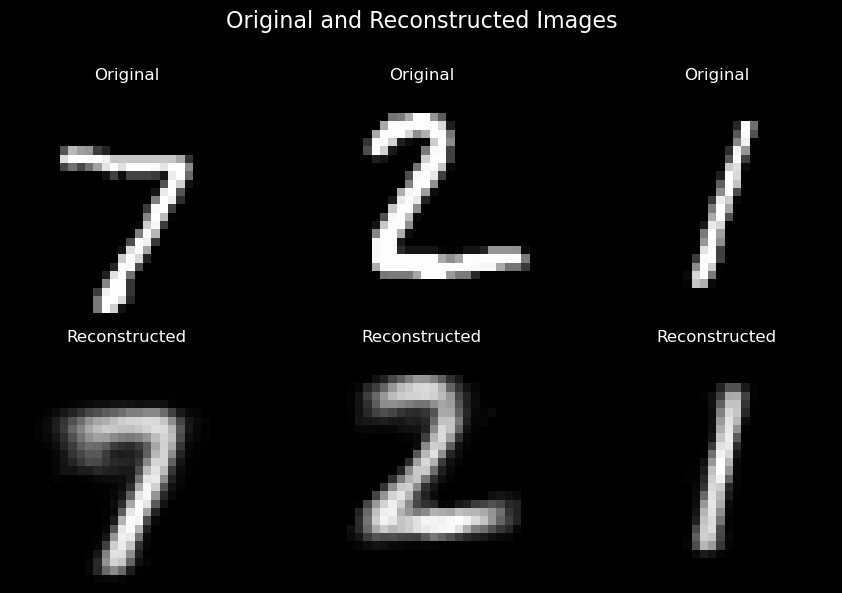

In [8]:
# Display Original and Reconstructed Images
def display_reconstructed_images(model, data_loader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))
    fig.suptitle("Original and Reconstructed Images", fontsize=16)

    with torch.no_grad():
        for i, (images, _) in enumerate(data_loader):
            images = images[:num_samples].to(device)
            reconstructed, _, _ = model(images)
            
            for j in range(num_samples):
                axes[0, j].imshow(images[j].cpu().squeeze(), cmap='gray')
                axes[0, j].axis("off")
                axes[0, j].set_title("Original")
            
            reconstructed_images = reconstructed.view(-1, 28, 28)
            for j in range(num_samples):
                axes[1, j].imshow(reconstructed_images[j].cpu().squeeze(), 
                                  cmap='gray')
                axes[1, j].axis("off")
                axes[1, j].set_title("Reconstructed")

            break
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

display_reconstructed_images(model, test_loader, num_samples=3)

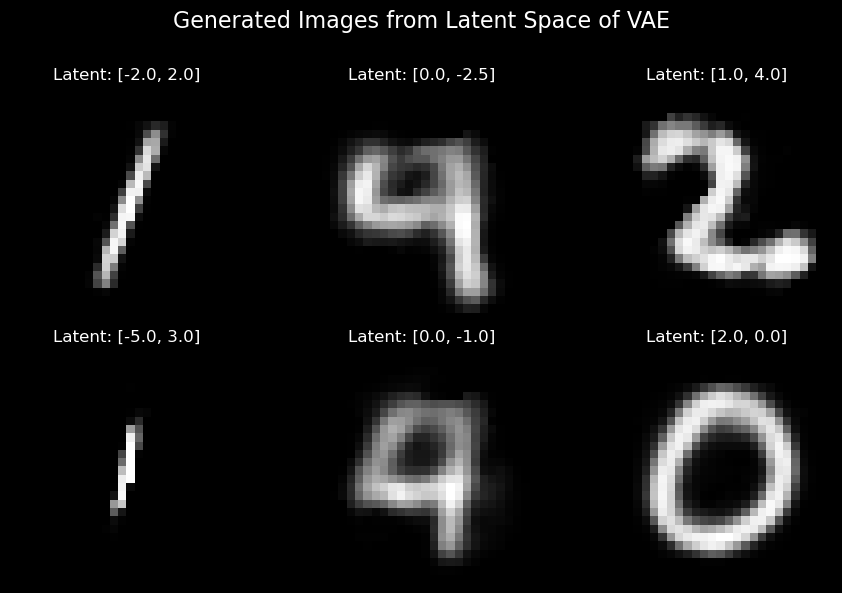

In [7]:
# Sample from Latent Space and Visualize
def sample_from_latent_space(model, latent_coords, grid_shape=(2, 3)):
    model.eval()
    latent_coords = torch.tensor(latent_coords, dtype=torch.float32, 
                                 device=device)

    with torch.no_grad():
        generated_images = model.decode(latent_coords).view(-1, 28, 28).cpu()

    fig, axes = plt.subplots(*grid_shape, figsize=(grid_shape[1] * 3, 
                                                   grid_shape[0] * 3))
    fig.suptitle("Generated Images from Latent Space of VAE", fontsize=16)
    axes = axes.flatten()

    for i, image in enumerate(generated_images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis("off")
        axes[i].set_title(f"Latent: {[round(x, 2) for x in latent_coords[i].tolist()]}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Generate the arrays for sampling
latent_space_coords = [
    [-2, 2],
    [0, -2.5],
    [1, 4],
    [-5, 3],
    [0, -1],
    [2, 0]
]
sample_from_latent_space(model, latent_space_coords, grid_shape=(2, 3))